In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.metrics import auc,roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle


In [2]:
#读入数据
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')
#查看数据行数和列数
print(train.shape)
print(test.shape)

(150000, 12)
(101503, 12)


In [3]:
#查看缺失值情况
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
test.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [5]:
process_df = train.iloc[:,[6,0,1,2,3,4,5,7,8,9]]
known = process_df[process_df.MonthlyIncome.notnull()].to_numpy()
unknown = process_df[process_df.MonthlyIncome.isnull()].to_numpy()
X = known[:, 1:]
y = known[:, 0]
z=unknown[:, 1:]

In [6]:
#对缺失值进行填充
#删除自动生成的行
train = train.drop(columns = ['Unnamed: 0'])
test = test.drop(columns = ['Unnamed: 0'])
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(),inplace=True)
train['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0], inplace=True)
#train=set_missing(train)

test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(),inplace=True)
test['NumberOfDependents'].fillna(test['NumberOfDependents'].mode()[0], inplace=True)
#test=set_missing(test)

#处理标签
train['SeriousDlqin2yrs'] = 1-train['SeriousDlqin2yrs']
test['SeriousDlqin2yrs'] = 1-test['SeriousDlqin2yrs']
# train.rename(columns={'SeriousDlqin2yrs':'信用评价','RevolvingUtilizationOfUnsecuredLines':'可用额度比值',
#                      'age':'年龄','NumberOfTime30-59DaysPastDueNotWorse':'30-59天逾期数','DebtRatio':'负债率',
#                      'MonthlyIncome':'月收入','NumberOfOpenCreditLinesAndLoans':'未结贷款数和信用额度',
#                      'NumberOfTimes90DaysLate':'90天或以上逾期数','NumberRealEstateLoansOrLines':'抵押和房地产贷款数量',
#                      'NumberOfTime60-89DaysPastDueNotWorse':'60-89天逾期数','NumberOfDependents':'家庭成员数'},inplace=True)
# test.rename(columns={'SeriousDlqin2yrs':'信用评价','RevolvingUtilizationOfUnsecuredLines':'可用额度比值',
#                      'age':'年龄','NumberOfTime30-59DaysPastDueNotWorse':'30-59天逾期数','DebtRatio':'负债率',
#                      'MonthlyIncome':'月收入','NumberOfOpenCreditLinesAndLoans':'未结贷款数和信用额度',
#                      'NumberOfTimes90DaysLate':'90天或以上逾期数','NumberRealEstateLoansOrLines':'抵押和房地产贷款数量',
#                      'NumberOfTime60-89DaysPastDueNotWorse':'60-89天逾期数','NumberOfDependents':'家庭成员数'},inplace=True)
train
test

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.00000,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.00000,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.00000,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.00000,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.00000,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0,0.068522,1400.00000,5,0,0,0,0.0
101499,NaN,0.922156,36,3,0.934217,7615.00000,8,0,2,0,4.0
101500,NaN,0.081596,70,0,836.000000,6855.03559,3,0,0,0,0.0
101501,NaN,0.335457,56,0,3568.000000,6855.03559,8,0,2,1,3.0


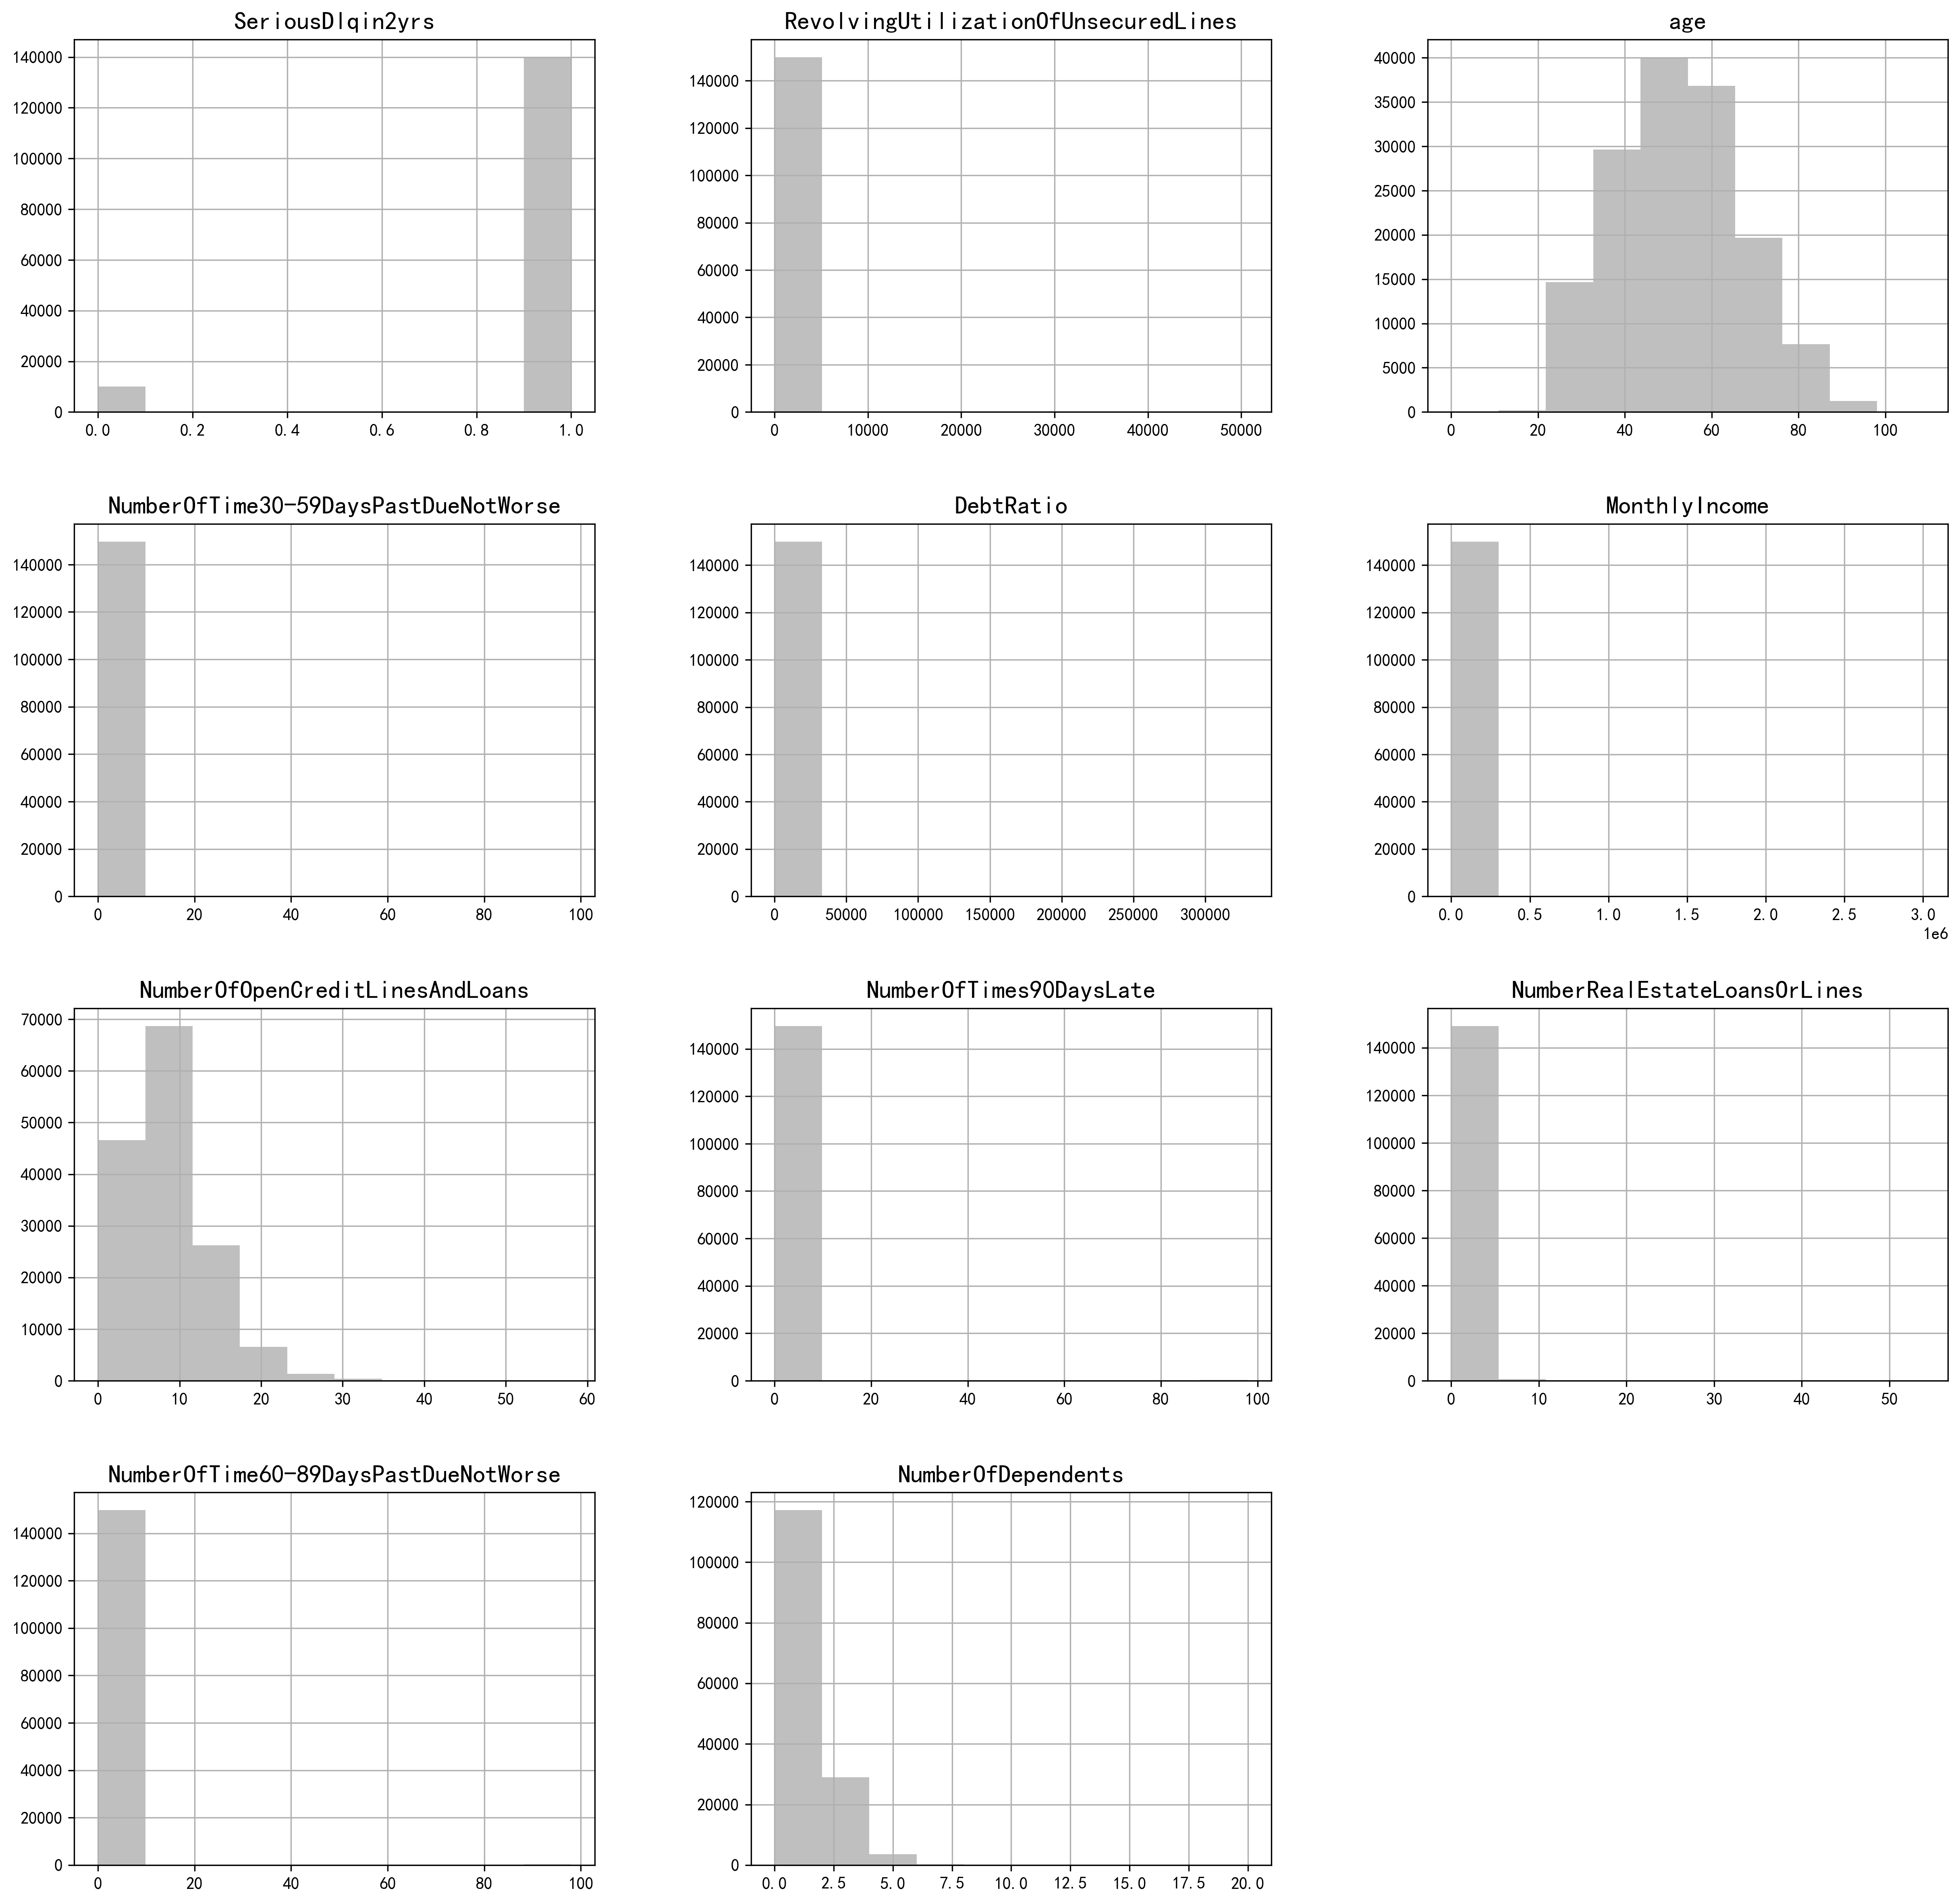

In [7]:
#画数据分布图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(train.columns):
    plt.subplot(4,3,n+1)
    plt.title(i,fontsize=15)
    plt.grid(linestyle='-')
    train[i].hist(color='grey',alpha=0.5)

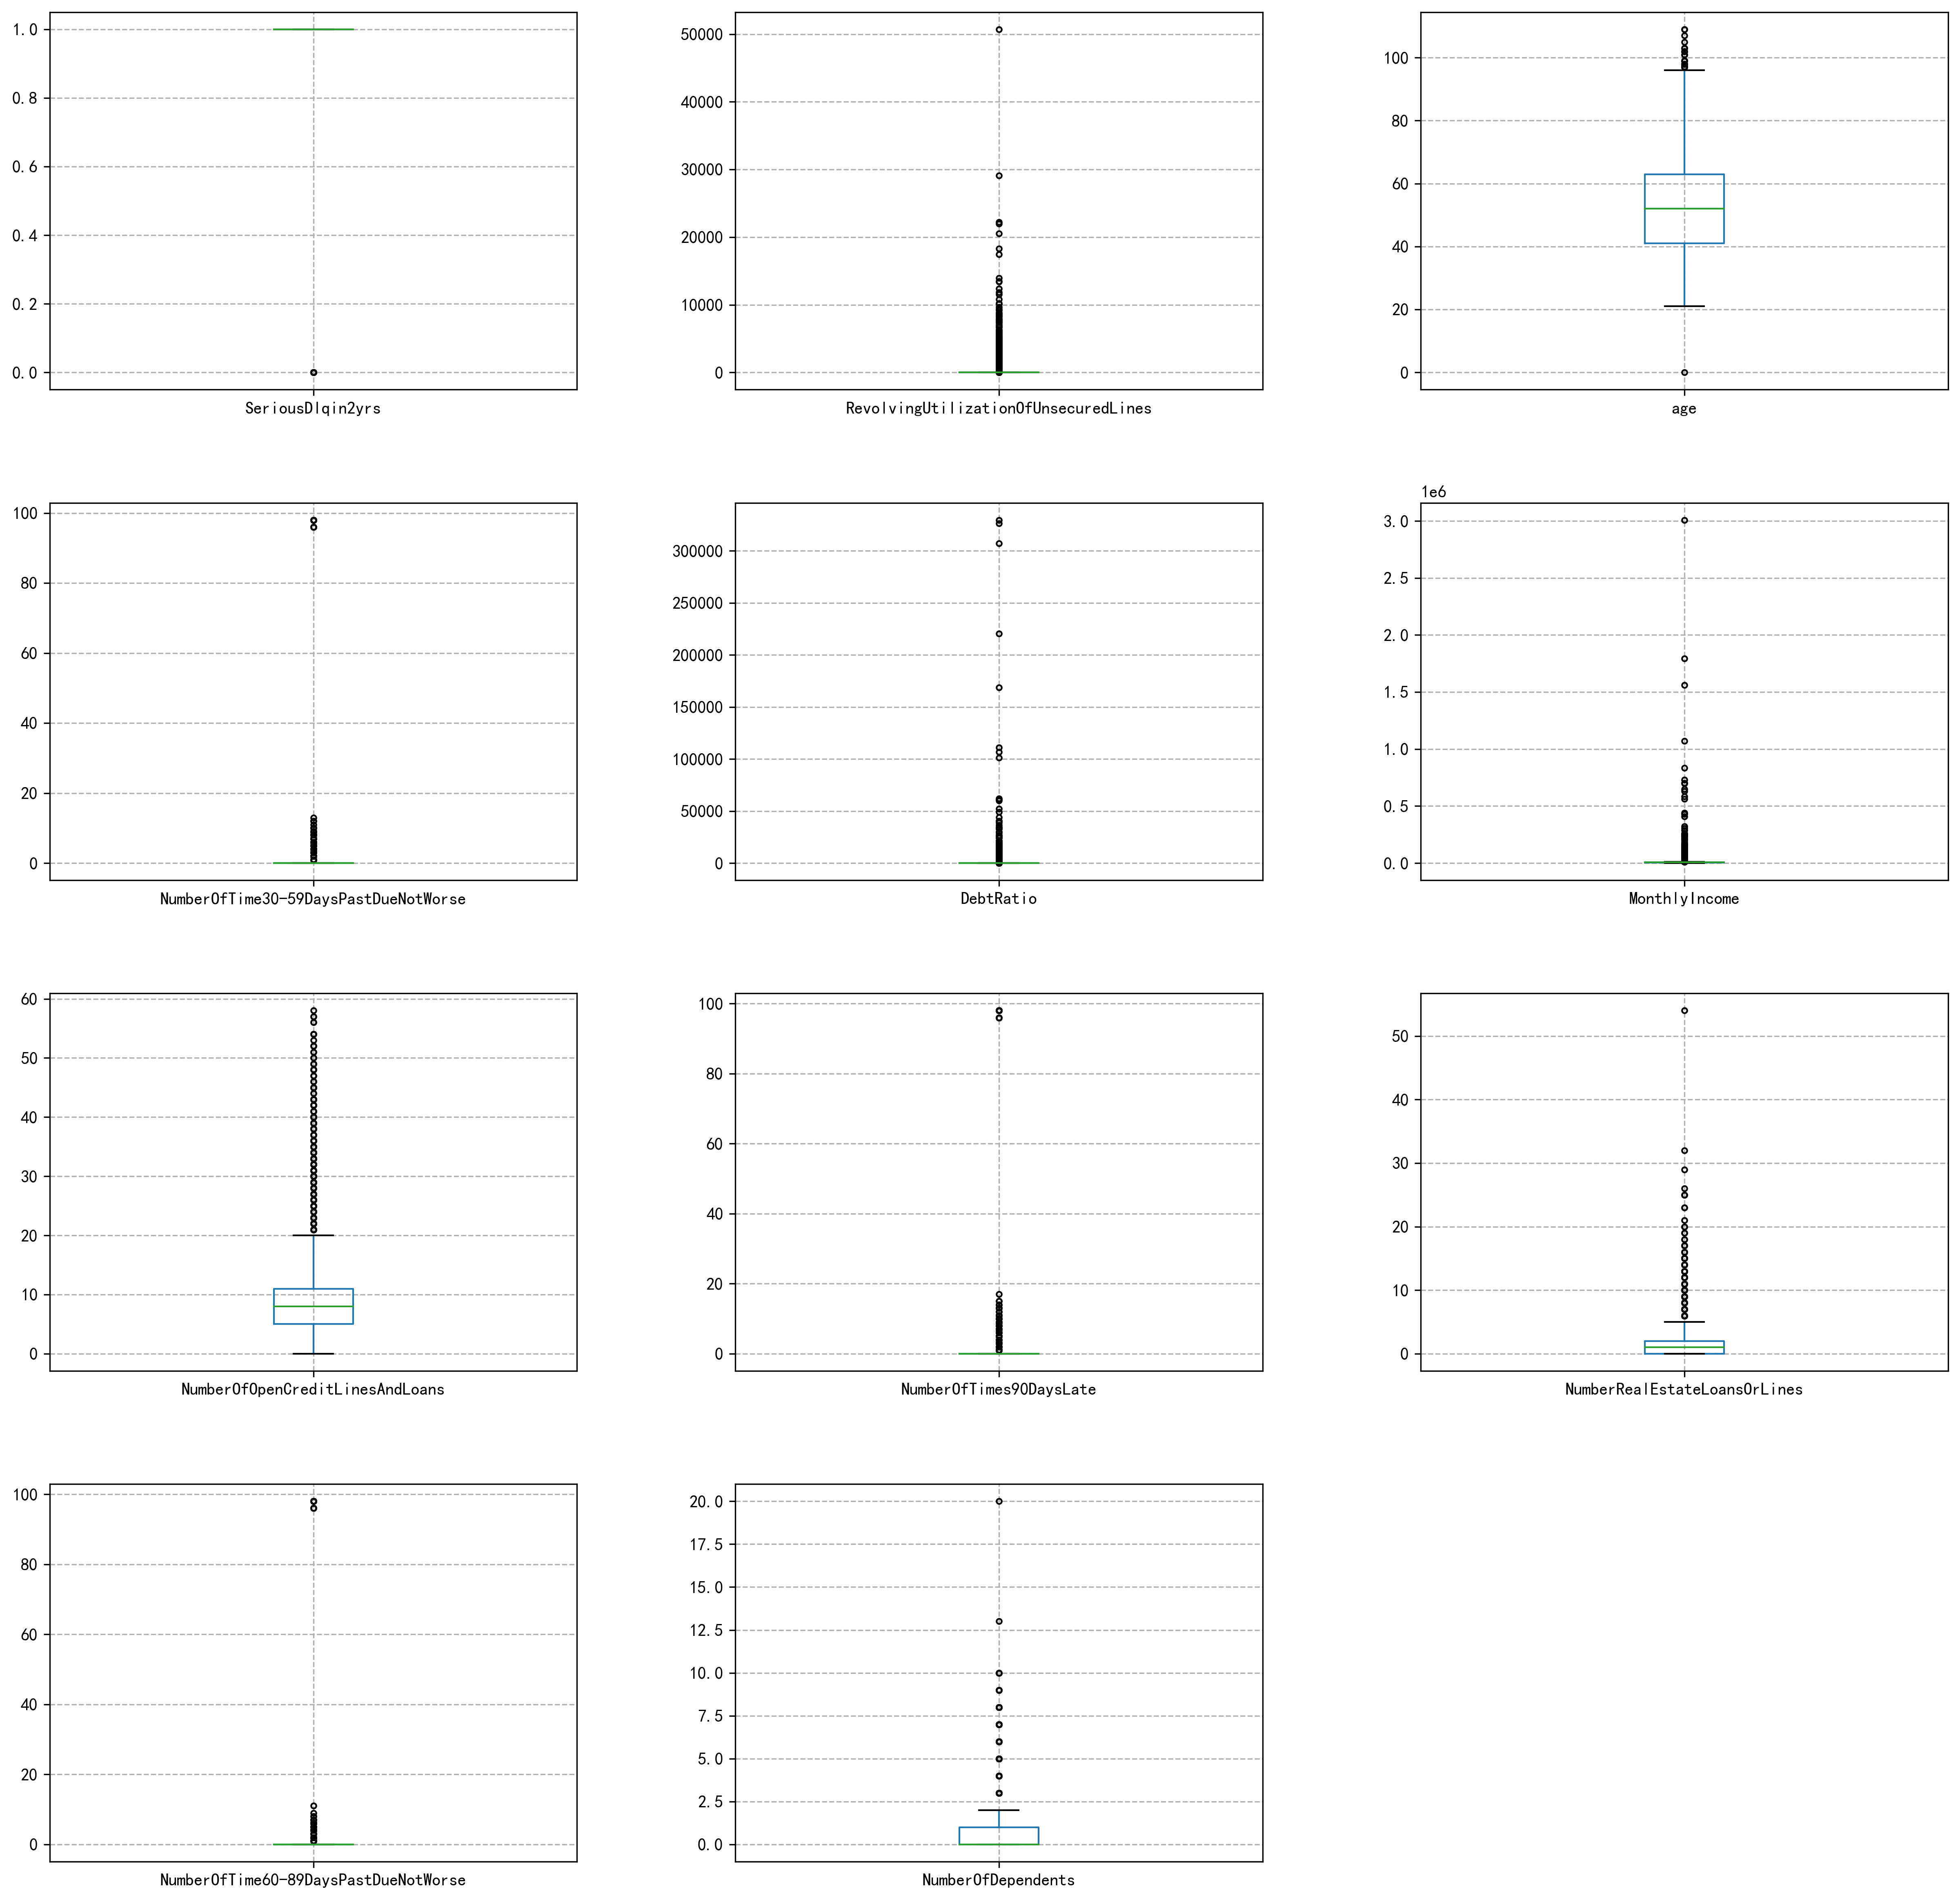

In [8]:
#画箱型图
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(train.columns):
    plt.subplot(4,3,n+1)
    plt.grid(linestyle='--')
    train[[i]].boxplot(sym='.')

In [9]:
#异常数据处理
def error_processing(df):
    n = len(df)
    
    df = df[df['RevolvingUtilizationOfUnsecuredLines'] <= 20000]

    df = df[(df['age']>18) & (df['age']<100)]

    df = df[df['NumberOfTime30-59DaysPastDueNotWorse']<80]

    df = df[df['NumberOfTimes90DaysLate']<80]

    df = df[df['NumberOfTime60-89DaysPastDueNotWorse']<80]

    df = df[df['DebtRatio']<100000]

    df = df[(df['MonthlyIncome']<500000)]#df.MonthlyIncome.isna()

    df = df[df['NumberRealEstateLoansOrLines']<20]

    df = df[(df['NumberOfDependents']<12)]#df.NumberOfDependents.isna()
    
    print('共删除数据 ',n - len(df),' 条。')
    return df

共删除数据  322  条。


<AxesSubplot:>

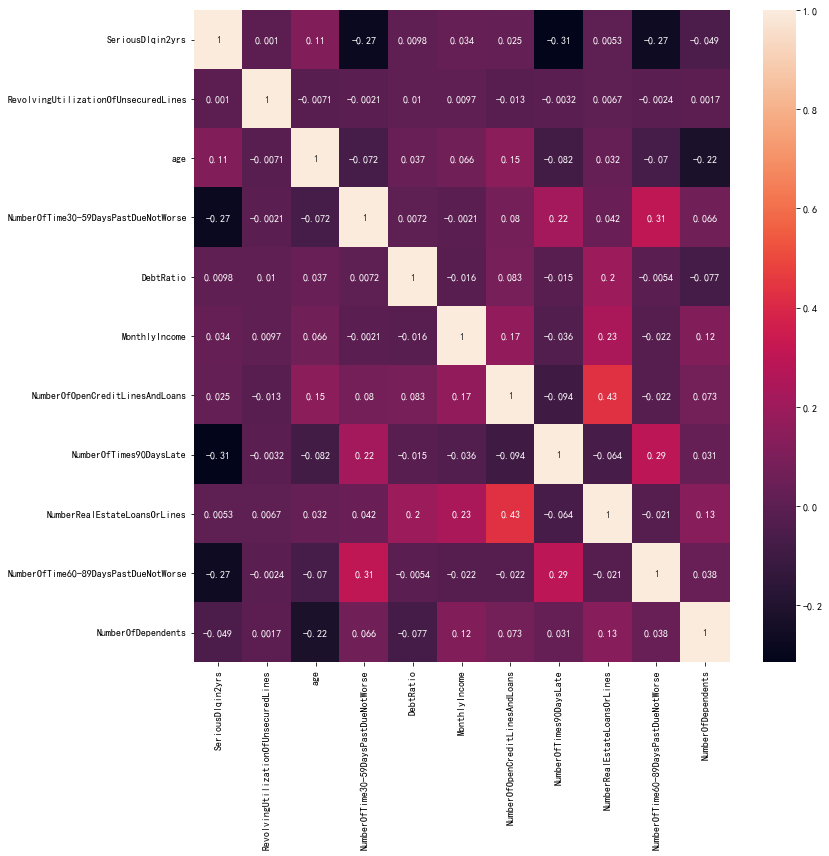

In [10]:
train1 = train.copy()
train1 = error_processing(train1)
cor=train1.corr()#计算相关系数
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,ax=ax)

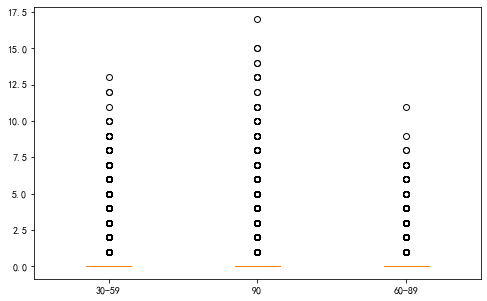

In [11]:
# 绘制箱型图
feature1 = train1['NumberOfTime30-59DaysPastDueNotWorse']
feature2 = train1['NumberOfTimes90DaysLate']
feature3 = train1['NumberOfTime60-89DaysPastDueNotWorse']
plt.figure(figsize=(8,5))#设置画布的尺寸
labels = '30-59','90','60-89',#图例
plt.boxplot([feature1,feature2, feature3], labels=labels)
plt.show()

1 93.52 % of the dataset
0 6.7 % of the dataset


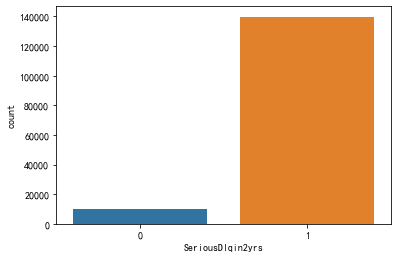

In [12]:
#计算两种数据占的比重
print('1', round(train['SeriousDlqin2yrs'].value_counts()[1]/len(train1) * 100,2), '% of the dataset')
print('0', round(train['SeriousDlqin2yrs'].value_counts()[0]/len(train1) * 100,2), '% of the dataset')
sns.countplot(x='SeriousDlqin2yrs',data=train1)
#画出直方图
plt.show()

In [13]:
#数据集平衡处理
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X = train1.drop('SeriousDlqin2yrs',1)#去掉标签
y = train1['SeriousDlqin2yrs']#用于拟合的结果
X,y=ros.fit_resample(X,y)
train1=pd.concat([X,y],axis=1,join='outer')
train1=shuffle(train1)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# X_test, y_test=ros.fit_resample(X_test,y_test)

1 50.0 % of the dataset
0 50.0 % of the dataset


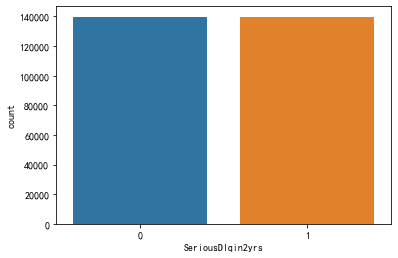

In [14]:
#处理后
print('1', round(train1['SeriousDlqin2yrs'].value_counts()[1]/len(train1) * 100,2), '% of the dataset')
print('0', round(train1['SeriousDlqin2yrs'].value_counts()[0]/len(train1) * 100,2), '% of the dataset')
sns.countplot(x='SeriousDlqin2yrs',data=train1)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
X = train1.drop('SeriousDlqin2yrs',1)#去掉标签
y = train1['SeriousDlqin2yrs']#用于拟合的结果
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_train=y_train.to_frame()
y_test=y_test.to_frame()
y_train.value_counts()

SeriousDlqin2yrs
0                   111906
1                   111778
dtype: int64

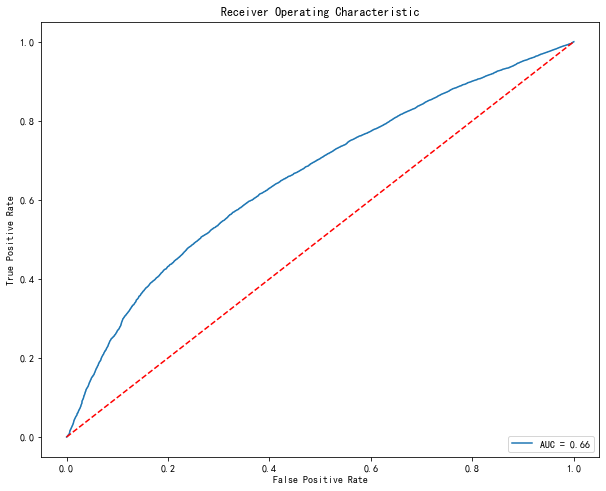

In [16]:
#使用逻辑回归模型进行拟合
from sklearn.linear_model import LogisticRegressionCV
logit = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], penalty='l1', solver='saga', max_iter=500, class_weight='balanced', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict_proba(X_test)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(223684, 10)
(223684, 1)
(55922, 10)
(55922, 1)


Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
223684/223684 [==============================] - 1s 6us/step - loss: 5.2770 - accuracy: 0.6004
Epoch 2/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.6064 - accuracy: 0.6766
Epoch 3/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5852 - accuracy: 0.6956
Epoch 4/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5659 - accuracy: 0.7122
Epoch 5/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5612 - accuracy: 0.7195
Epoch 6/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5572 - accuracy: 0.7240
Epoch 7/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5798 - accuracy: 0.7101
Epoch 8/20
223684/223684 [==============================] - 1s 5us/step - loss: 0.5531 - accuracy: 0.7277
Epoch 9/20
223684/223684 [==============================]

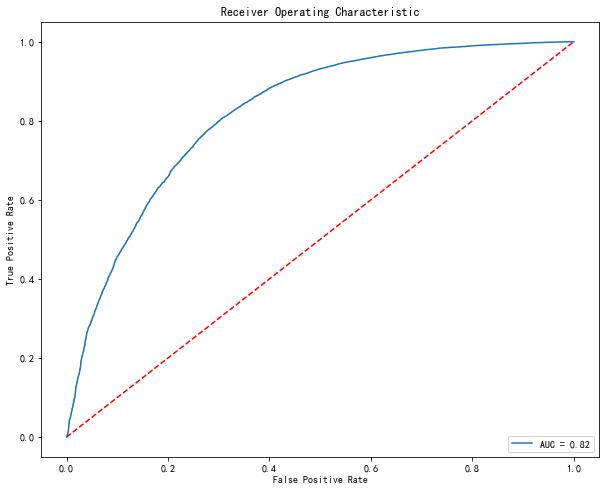

In [18]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
import tensorflow as tf

model=Sequential()
model.add(Dense(16,input_shape=(10,),activation='relu',init='uniform'))#隐藏层
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))#输出层
#opt=optimizers.SGD(lr=0.01)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=500,epochs=20)
score=model.evaluate(X_test,y_test)
print(score)

y_pred=model.predict(X_test)
#y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()